<span style="color:blue; font-size:24px;"><b>BERTopic analysis of university complaints</b></span>

<span style="color:orange; font-size:18px;"><b>0. Loading the data</b></span>

In [34]:
import os
import sys
import pandas as pd

# Project root path
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(BASE_DIR)

DATA_PATH = os.path.join(BASE_DIR, "data", "raw", "Datasetprojpowerbi.csv")
df = pd.read_csv(DATA_PATH)

texts = df["Reports"].tolist()
print(f"Loaded {len(texts)} docs.")

Loaded 1005 docs.


<span style="color:orange; font-size:18px;"><b>1. Cleaning and tokenizing</b></span>

In [35]:
from src.preprocessing.clean_for_bert import clean_texts_bert

# 1. Normalization
cleaned_texts = clean_texts_bert(texts)

print(f"Cleaned and tokenized {len(cleaned_texts)} docs.")

Cleaned and tokenized 1005 docs.


<span style="color:orange; font-size:18px;"><b>2. Stopwords and vectorization </b></span>

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

english_stopwords = stopwords.words('english')
domain_stopwords = [    
    "make", "need", "hard", "difficult", "wish", "really", "feel", "experience",
    "get", "feel_like", "often", "student", "university", "lack", "take", "enough",
    "challenge", "limited", "important", "try", "keep", "high", "way", "always", "due", 
    "would", "afford", "would_great", "like", "able", "affordable", "different", "seem",
    "especially", "could", "frustrating", "im", "ive", "us", "seems", "shouldnt", "clearly",
    "dont", "think", "great", "even", "making", "given", "doesnt", "challenging", "anything",
    "much", "shows", "seems", "still", "near", "new", "made", "causing", "worried", "going",
    "constantly", "better", "unacceptable", "give", "one", "causing"
]

all_stopwords = english_stopwords + domain_stopwords
vectorizer = CountVectorizer(stop_words=all_stopwords)    # This is a BoW vectorizer to describe clusters built by BERTopic

<span style="color:orange; font-size:18px;"><b>3. Training BERTopic model</b></span>

In [37]:
from src.topic_models.bertopic_model import train_bertopic, print_topics

bert_model, topics = train_bertopic(cleaned_texts, nr_topics=12, verbose=True, vectorizer=vectorizer)   # we set 12 topics to get 11 definined topics + "the rest" with number -1

print_topics(bert_model, top_n_words=20)

2025-11-21 19:51:03,373 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-11-21 19:51:05,806 - BERTopic - Embedding - Completed ✓
2025-11-21 19:51:05,806 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-21 19:51:06,369 - BERTopic - Dimensionality - Completed ✓
2025-11-21 19:51:06,370 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-21 19:51:06,380 - BERTopic - Cluster - Completed ✓
2025-11-21 19:51:06,380 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-21 19:51:06,396 - BERTopic - Representation - Completed ✓
2025-11-21 19:51:06,397 - BERTopic - Topic reduction - Reducing number of topics
2025-11-21 19:51:06,398 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-21 19:51:06,409 - BERTopic - Representation - Completed ✓
2025-11-21 19:51:06,409 - BERTopic - Topic reduction - Reduced number of topics from 25 to 12


Topic 0: students, international, language, cultural, sometimes, transportation, housing, campus, learn, rent, opportunities, bus, public, love, find, activities, events, community, options, area
Topic 1: online, access, classes, materials, research, course, databases, software, technology, availability, complete, resources, assignments, accessing, students, coursework, academic, professors, inperson, technical
Topic 2: financial, health, pay, medical, care, expenses, aid, mental, cost, insurance, tuition, debt, college, loan, struggling, ends, money, cover, scholarships, help
Topic 3: options, cafeteria, campus, food, cantine, offer, available, overpriced, quality, stale, snacks, prices, machines, vending, healthy, dining, breakfast, eat, store, fresh
Topic 4: job, opportunities, internships, field, career, networking, students, internship, offer, market, available, find, professionals, jobs, connect, development, gain, despite, provide, events
Topic 5: academic, workload, time, respo

<span style="color:orange; font-size:18px;"><b>4. Saving the model</b></span>

In [38]:
from src.topic_models.lsa_lda_models import save_model

os.makedirs(os.path.join(BASE_DIR, "models", "bertopic"), exist_ok=True)

save_path = os.path.join(BASE_DIR, "models", "bertopic", "bert_model_1.pkl")
save_model(bert_model, save_path)

print(f"Model is saved to {save_path}")

2025-11-21 19:51:14,512 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Model is saved to /home/dmitry/Projects/IU_claims/models/bertopic/bert_model_1.pkl


<span style="color:orange; font-size:18px;"><b>5. Topic histogram</b></span>

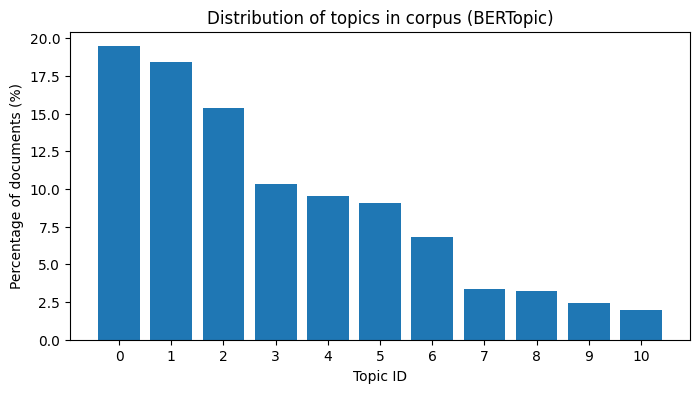

In [39]:
from collections import Counter
import matplotlib.pyplot as plt

topic_counts = Counter(topics)

# Exclude outliers (-1)
topic_ids = [tid for tid in topic_counts if tid != -1]
counts = [topic_counts[tid] for tid in topic_ids]

# Percentage
total_docs = len([t for t in topics if t != -1])
percentages = [(c / total_docs) * 100 for c in counts]

# Histogram
plt.figure(figsize=(8,4))
plt.bar(topic_ids, percentages)
plt.xticks(topic_ids)
plt.ylabel("Percentage of documents (%)")
plt.xlabel("Topic ID")
plt.title("Distribution of topics in corpus (BERTopic)")

plt.show()

<span style="color:orange; font-size:18px;"><b>6. Topic summary done by ChatGPT based on 20 words for each topic</b></span>

<h1>Student Complaints Topic Summary (BERTopic)</h1>

<h2>Topic 0: Student Life & Campus Environment</h2>
<p>This topic covers students discussing campus life, including housing, transportation, events, cultural experiences, and community engagement. Students mention opportunities for learning and social activities as part of their overall campus experience.</p>
<p class="keywords">Key words: students, international, language, cultural, transportation, housing, campus, learn, rent, opportunities, bus, public, activities, events, community, options, area</p>

<h2>Topic 1: Online Access & Course Materials</h2>
<p>This topic focuses on challenges with accessing online classes, course materials, software, and databases. Students highlight issues completing assignments, using academic resources, and interacting with professors both online and in-person.</p>
<p class="keywords">Key words: online, access, classes, materials, research, course, databases, software, technology, availability, complete, resources, assignments, accessing, coursework, academic, professors, inperson, technical</p>

<h2>Topic 2: Financial & Health Concerns</h2>
<p>This topic deals with financial and health-related challenges, including tuition, loans, insurance, medical care, and mental health support. Students discuss expenses, scholarships, and difficulties managing finances while attending college.</p>
<p class="keywords">Key words: financial, health, pay, medical, care, expenses, aid, mental, cost, insurance, tuition, debt, college, loan, struggling, ends, money, cover, scholarships, help</p>

<h2>Topic 3: Campus Food & Cafeteria Issues</h2>
<p>This topic covers complaints and discussions about food options on campus, including cafeterias and vending machines. Students note quality, pricing, freshness, and availability of meals and snacks.</p>
<p class="keywords">Key words: options, cafeteria, campus, food, cantine, offer, available, overpriced, quality, stale, snacks, prices, machines, vending, healthy, dining, breakfast, eat, store, fresh</p>

<h2>Topic 4: Career Opportunities & Internships</h2>
<p>This topic focuses on students seeking job and internship opportunities, networking, and professional development. Discussions include finding positions, market availability, and connecting with professionals despite challenges.</p>
<p class="keywords">Key words: job, opportunities, internships, field, career, networking, students, internship, offer, market, available, find, professionals, jobs, connect, development, gain, despite, provide, events</p>

<h2>Topic 5: Academic Workload & Stress</h2>
<p>This topic highlights challenges with academic workload, responsibilities, and stress management. Students discuss time management, balancing work and life, conflicts, anxiety, and feeling overwhelmed by commitments.</p>
<p class="keywords">Key words: academic, workload, time, responsibilities, work, commitments, stress, anxiety, mental, health, balance, sleep, balancing, feeling, conflicts, manage, affecting, finding, struggling, overwhelming</p>

<h2>Topic 6: Sports & Athletics</h2>
<p>This topic concerns campus sports, athletic programs, team eligibility, and gender issues. Students discuss requirements, resources, injuries, inclusivity, and support for athletes.</p>
<p class="keywords">Key words: sports, athletic, athletes, eligibility, gender, team, requirements, teams, inequality, culture, injuries, sportsrelated, needs, resources, prioritize, support, students, exclusive, womens, strict</p>

<h2>Topic 7: Courses & Academic Performance</h2>
<p>This topic deals with courses, professors, grading, and academic expectations. Students mention understanding material, struggling with learning, and concerns about fairness, integrity, and educational outcomes.</p>
<p class="keywords">Key words: course, professor, material, understand, expected, grading, grade, know, class, struggling, learning, integrity, favorites, teaching, education, concerned, higher, textbook, success, extremely</p>

<h2>Topic 8: Administrative & Office Processes</h2>
<p>This topic covers administrative processes such as certificate applications, document processing, and requests. Students highlight delays, communication challenges, and navigating office procedures.</p>
<p class="keywords">Key words: affairs, office, certificate, certificates, needs, processed, application, processes, birth, weeks, time, military, managing, process, multiple, training, requests, students, communication, wait</p>

<h2>Topic 9: Food & Dining Complaints</h2>
<p>This topic focuses on issues related to campus dining halls, including meal quality, availability, and incidents such as theft or hygiene problems. Students express frustration with the food service experience.</p>
<p class="keywords">Key words: food, unable, hall, dining, cooked, liking, find, seen, served, available, options, ordered, stolen, harassed, meets, insects, gotten, appealing, charged, assaulted</p>

<h2>Topic 10: Academic Advisors & Guidance</h2>
<p>This topic highlights students' interactions with academic advisors, guidance, and support for degree planning and career development. Concerns include lack of support, unanswered questions, and navigating academic programs.</p>
<p class="keywords">Key words: advisors, academic, access, plan, support, careers, guidance, degree, guide, unsupported, succeed, questions, receiving, career, academically, help, program, available, decisions, cares</p>

